In [1]:
from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType
from inference_schema.parameter_types.standard_py_parameter_type import StandardPythonParameterType
from azureml.automl.core import inference
from azureml.automl.dnn.nlp.common.constants import ScoringLiterals, OutputLiterals

import numpy as np
import pandas as pd
import json
import pickle
import os

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/jinja2/environment.py:471: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [4]:
data_sample = PandasParameterType(pd.DataFrame({"Question": pd.Series(["example_value"], dtype="object")}))
input_sample = StandardPythonParameterType({'data': data_sample})
method_sample = StandardPythonParameterType("predict")
sample_global_params = StandardPythonParameterType(1.0)

result_sample = NumpyParameterType(np.array(["example_value"]))
output_sample =  StandardPythonParameterType({'Results':result_sample})

os.environ["AZUREML_MODEL_DIR"] = os.path.abspath(os.getcwd())
os.environ["MODEL_FILE_NAME"] = "model.pkl"

def init():
    os.environ["AZUREML_MODEL_DIR_ENV"] = os.path.abspath(os.getcwd())
    os.environ["MODEL_FILE_NAME"] = "model.pkl"
    """This function is called during inferencing environment setup and initializes the model"""
    global model
    model_path = os.path.join(os.getenv(ScoringLiterals.AZUREML_MODEL_DIR_ENV), OutputLiterals.MODEL_FILE_NAME)
    print(model_path)
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
init()

In [67]:
def custom_run(Inputs, GlobalParameters=1.0) -> str:
    """ This is called every time the endpoint is invoked. It returns the prediction of the input data

    :param data: input data provided by the user
    :type data: pd.DataFrame
    :return: json string of the result
    :rtype: str
    """
    data = Inputs["data"]
    fin_outputs = model.predict_proba(data)
    classes = model.classes_
    concatenated_lists = [list(zip(classes, single_output)) for single_output in fin_outputs]
    return concatenated_lists

In [82]:
data = {"data": pd.DataFrame({"Question": pd.Series(["How do I restore deleted items in OneDrive?","Thank you very much"], dtype="object")})}

In [83]:
custom_run(data)

[[('HR', 0.007832562),
  ('IT', 0.9905098),
  ('Servicing', 0.010060785),
  ('ServicingData', 0.0090904),
  ('Welcome', 0.0074028424)],
 [('HR', 0.027629567),
  ('IT', 0.02649772),
  ('Servicing', 0.024626238),
  ('ServicingData', 0.026868746),
  ('Welcome', 0.9744387)]]

In [106]:
def run(Inputs, GlobalParameters=1.0) -> str:
    """ This is called every time the endpoint is invoked. It returns the prediction of the input data

    :param data: input data provided by the user
    :type data: pd.DataFrame
    :return: json string of the result
    :rtype: str
    """
    data = Inputs["data"]
    fin_outputs = model.predict(data)
    return {"Results": [list(item) for item in fin_outputs]}

In [107]:
run(data)

{'Results': [['IT'], ['Welcome']]}

### Import validation file

In [108]:
validation = pd.read_csv("Validation.csv")

In [109]:
validation_data = {"data": validation}

In [113]:
validation['predictions'] = [prediction[0] for prediction in run(validation_data)['Results']]

In [114]:
validation

,Question,Topic,predictions
0,What is escrow?,Servicing,Servicing
1,Provide details about Forbearance loss mit ret...,Servicing,Servicing
2,What all liquidation options offered for loss ...,Servicing,Servicing
3,Do I need a Divorce Decree to evaluate loss mi...,Servicing,Servicing
4,give me the guidelines for Transferring Calls ...,Servicing,Servicing
5,What is the process for reviewing a VA loan fo...,Servicing,Servicing
6,How do I handle a REO account??,Servicing,Servicing
7,How do I handle an account that is in foreclos...,Servicing,Servicing
8,How do I handle an account where the homeowner...,Servicing,Servicing
9,What is motion for relief?,Servicing,Servicing


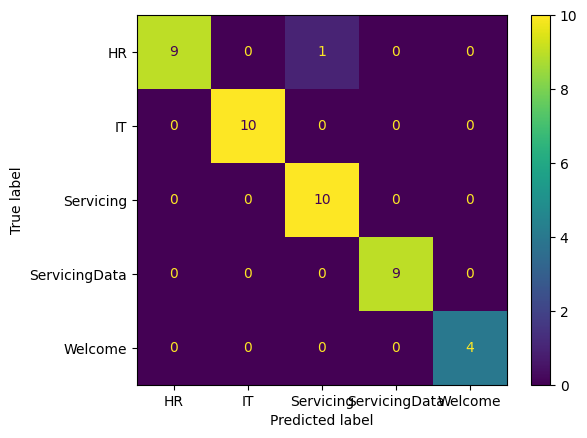

In [119]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(validation['Topic'], validation['predictions'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = model.classes_)

cm_display.plot()
plt.show()

In [120]:
from sklearn.metrics import confusion_matrix, classification_report

In [121]:
print(classification_report(validation['Topic'], validation['predictions']))

               precision    recall  f1-score   support

           HR       1.00      0.90      0.95        10
           IT       1.00      1.00      1.00        10
    Servicing       0.91      1.00      0.95        10
ServicingData       1.00      1.00      1.00         9
      Welcome       1.00      1.00      1.00         4

     accuracy                           0.98        43
    macro avg       0.98      0.98      0.98        43
 weighted avg       0.98      0.98      0.98        43

